In [1]:
import os
from deepst.DeepST import run
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
import random
import torch
from pathlib import Path
import pandas as pd
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
data_path = "./data/mel1"   # to your path
data_name = 'rep1'          # project name
save_path = "./results"     # save path
n_domains = 5               # the number of spatial domains.
set_seed(88)

deepen = run(save_path = save_path,
			 task = "Identify_Domain", #### DeepST includes two tasks, one is "Identify_Domain" and the other is "Integration"
			 )
adata = sc.read_h5ad('./data/mel1/rep1/ST_mel1_rep1_ST_processed.h5ad')
hidpi_adata = adata.copy()

In [4]:
# gene_counts = np.sum(adata.X > 0, axis=0)
# gene_fraction = gene_counts / adata.n_obs
# highly_expressed_genes = gene_fraction > 0.8
# adata = adata[:, ~highly_expressed_genes]

# adata = deepen._get_augment(adata, spatial_type="BallTree", spatial_k=15 ,use_morphological=False)
adata = deepen._get_augment(adata, spatial_type="BallTree", use_morphological=False)
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")
data = deepen._data_process(adata,pca_n_comps = 200)

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]

Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!


In [5]:
deepen = run(save_path = save_path,
			 task = "Identify_Domain", #### DeepST includes two tasks, one is "Identify_Domain" and the other is "Integration"
			 pre_epochs = 50, ####  choose the number of training
			 epochs = 100, #### choose the number of training
			 )

In [6]:
deepst_embed = deepen._fit(
		data = data,
		graph_dict = graph_dict,
		Conv_type = "GCNConv",
		)
adata.obsm["DeepST_embed"] = deepst_embed

Your task is in full swing, please wait


DeepST trains an initial model:   0%|           [ time left: ? ]

DeepST trains a final model:   0%|           [ time left: ? ]

Step 3: DeepST training has been Done!
Current memory usage：1.6126 GB
Total time: 0.09 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data


In [7]:
adata = deepen._get_cluster_data(adata, n_domains, priori = True)

 68%|██████▊   | 164/240 [00:01<00:00, 132.85it/s]

Best resolution:  0.8499999999999996


In [8]:
save_name = "results1"
adata.write_h5ad(f"{save_path}/{save_name}.h5ad")
clusters_dir = Path(f'{data_path}/{data_name}/')
pd1 = pd.DataFrame(adata.obs['clusters'].tolist(), columns=['layer_guess'], index=adata.obs['clusters'].index)
pd1.to_csv(f'{clusters_dir}/metadata.tsv', sep='\t', index=True)

In [9]:
from score import calculate_cluster_score
cluster_score = calculate_cluster_score(data_name, data_path, save_path, save_name)

       layer_guess
21x12            0
16x20            0
16x19            0
18x16            0
17x19            0
...            ...
4x12             4
4x11             4
17x16            4
22x15            4
2x9              4

[279 rows x 1 columns]
===== Project: rep1 ARI score: 0.721 =====
===== Project: rep1 NMI score: 0.785 =====


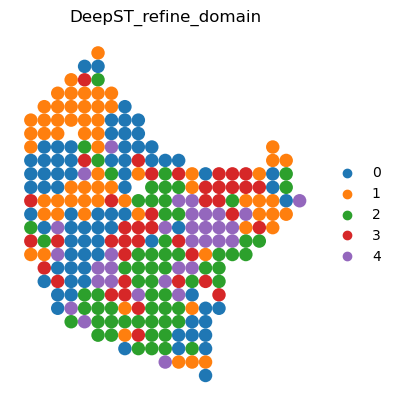

<Figure size 640x480 with 0 Axes>

In [10]:
sc.pl.spatial(adata, color='DeepST_refine_domain', frameon = False, spot_size=1)
plt.savefig(os.path.join(save_path, f'{data_name}_domains.pdf'), bbox_inches='tight', dpi=300)

In [11]:
from enhanceST import *
hidpi_adata
hidpi_adata.X = csr_matrix(hidpi_adata.X)
coords = hidpi_adata.obsm['spatial']
hidpi_adata.obs['array_row'] = coords[:, 0]  # 提取行坐标
hidpi_adata.obs['array_col'] = coords[:, 1]  # 提取列坐标

In [12]:
hidpi_adata.var_names_make_unique()
integral_coords = hidpi_adata.obs[['array_row', 'array_col']]

# QC
sc.pp.calculate_qc_metrics(hidpi_adata, inplace=True)
sc.pp.filter_cells(hidpi_adata, min_genes=200)
sc.pp.filter_genes(hidpi_adata, min_cells=10)

# Genes expressed over ten percent of total spots
good_adata = hidpi_adata[:, hidpi_adata.var["n_cells_by_counts"] > len(hidpi_adata.obs.index) * 0.1]
n_samples = good_adata.shape[0]
np.random.seed(42)
indices = np.random.permutation(n_samples)

# 按 8:2 比例划分索引
split_point = int(n_samples * 0.8)
train_idx, val_idx = indices[:split_point], indices[split_point:]

# 创建两个新的 AnnData 对象
good_adata_train = good_adata[train_idx].copy()
good_adata_val = good_adata[val_idx].copy()

# Get count matrix and coordinate matrix, they are inputs of DIST algorithm.
train_counts = np.array(good_adata_train.X.todense())
train_coords = good_adata_train.obs[['array_row', 'array_col']]
val_counts = np.array(good_adata_val.X.todense())
val_coords = good_adata_val.obs[['array_row', 'array_col']]

# this test is full size
test_adata = hidpi_adata
test_counts = np.array(test_adata.X.todense())
test_coords = test_adata.obs[['array_row', 'array_col']]

In [13]:
train_set = getSTtrainset(train_counts, train_coords)
val_set = getSTtrainset(val_counts, val_coords)
test_set = getSTtestset(test_counts, test_coords)
position_info, imputed_to_integral_mapping = get_ST_position_info(integral_coords)

Creating training set costs:  1.64 s
Creating training set costs:  1.17 s
Creating testing set costs:  2.21 s


In [14]:
imputed_img, losses_list, val_losses_list = enhanceST(train_set, val_set, test_set, epoch=800, batch_size=128, gpu=0)

Single Train data
Single Validation data
Epoch 1/800, loss: 0.0824, val_loss: 0.0342, time_per_epoch: 0.7921
Epoch 2/800, loss: 0.0599, val_loss: 0.0341, time_per_epoch: 0.3287
Epoch 3/800, loss: 0.0567, val_loss: 0.0338, time_per_epoch: 0.3410
Epoch 4/800, loss: 0.0547, val_loss: 0.0309, time_per_epoch: 0.3437
Epoch 5/800, loss: 0.0496, val_loss: 0.0290, time_per_epoch: 0.3145
Epoch 6/800, loss: 0.0468, val_loss: 0.0298, time_per_epoch: 0.3279
Epoch 7/800, loss: 0.0447, val_loss: 0.0302, time_per_epoch: 0.3285
Epoch 8/800, loss: 0.0435, val_loss: 0.0302, time_per_epoch: 0.3265
Epoch 9/800, loss: 0.0439, val_loss: 0.0303, time_per_epoch: 0.3415
Epoch 10/800, loss: 0.0430, val_loss: 0.0302, time_per_epoch: 0.3371
Epoch 11/800, loss: 0.0432, val_loss: 0.0302, time_per_epoch: 0.3196
Epoch 12/800, loss: 0.0443, val_loss: 0.0301, time_per_epoch: 0.3345
Epoch 13/800, loss: 0.0440, val_loss: 0.0298, time_per_epoch: 0.3190
Epoch 14/800, loss: 0.0426, val_loss: 0.0303, time_per_epoch: 0.3275
Ep

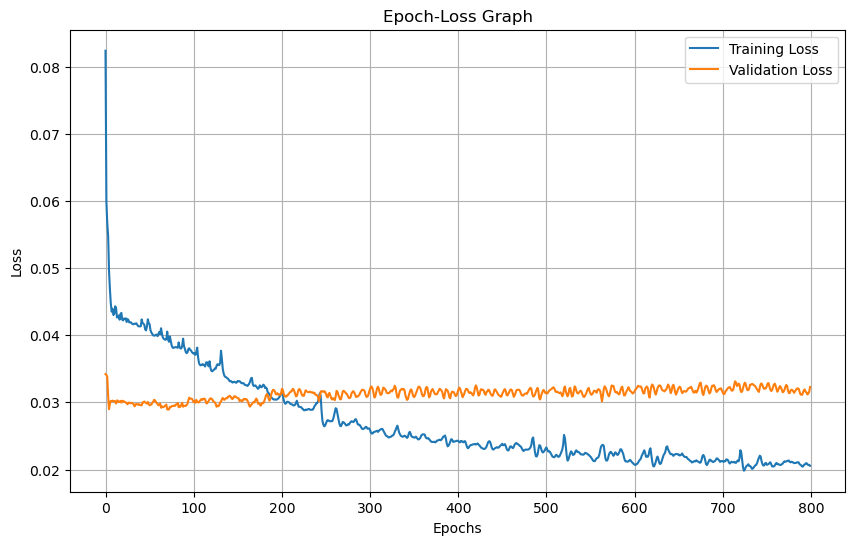

In [15]:
# Plotting the epoch-loss graph
plt.figure(figsize=(10, 6))
plt.plot(losses_list, label='Training Loss')
plt.plot(val_losses_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch-Loss Graph')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
imputed_counts, imputed_coords = img2expr(imputed_img, test_adata.var_names, integral_coords, position_info)

In [17]:
imputed_adata = ad.AnnData(X=imputed_counts, obs=imputed_coords)
imputed_adata.X = csr_matrix(imputed_adata.X)
imputed_adata.var = hidpi_adata.var

In [18]:
from scipy.interpolate import griddata

# 从 adata 中提取原始点的行列坐标和空间坐标
original_coords = hidpi_adata.obs[['array_row', 'array_col']].values
original_spatial = hidpi_adata.obsm['spatial']
# 从 imputed_adata 中提取新数据的行列坐标
new_coords = imputed_adata.obs[['array_row', 'array_col']].values
# 使用 griddata 插值生成新的点的空间坐标
new_spatial = griddata(original_coords, original_spatial, new_coords, method='linear')

# 将生成的空间坐标添加到 imputed_adata 中
imputed_adata.obsm['spatial'] = new_spatial
imputed_adata.uns = hidpi_adata.uns

In [19]:
# library_id = list(hidpi_adata.uns["spatial"].keys())[0]
# quality ='hires'
# scale = hidpi_adata.uns["spatial"][library_id]["scalefactors"][
#             "tissue_" + quality + "_scalef"]
# scale

In [20]:
# image_coor = imputed_adata.obsm["spatial"] * scale
# imputed_adata.obs["imagecol"] = image_coor[:, 0]
# imputed_adata.obs["imagerow"] = image_coor[:, 1]
# imputed_adata.uns["spatial"][library_id]["use_quality"] = quality

In [21]:
imputed_adata.write_h5ad(f"{data_path}/{data_name}2.h5ad")

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_genes(hidpi_adata, show_genes, n=4, size=(20,5),point_size=30, titles=None,cmap=None):
    if titles==None:
        titles=show_genes
    genes_index=[list(hidpi_adata.var_names).index(gene) for gene in show_genes]
    m=len(show_genes)//n+1
    plt.figure(figsize=size)
    flag=0
    for j in range(m):
        show_genes0=show_genes[j*n:min(len(show_genes),(j+1)*n)]
        
        for i in range(n):
            if not i<len(show_genes0):
                break
            plt.subplot(m,n,flag+1)
        
            plt.scatter(hidpi_adata.obs['array_col'],hidpi_adata.obs['array_row'],c=np.array(hidpi_adata.X.todense())[:,genes_index[flag]],
                        marker='s',s=point_size, vmin=0,cmap=cmap)
            plt.title(titles[flag])
            plt.xticks([])
            plt.yticks([])
            plt.gca().invert_yaxis()
            plt.gca().invert_xaxis()
            plt.axis('off')
            flag+=1

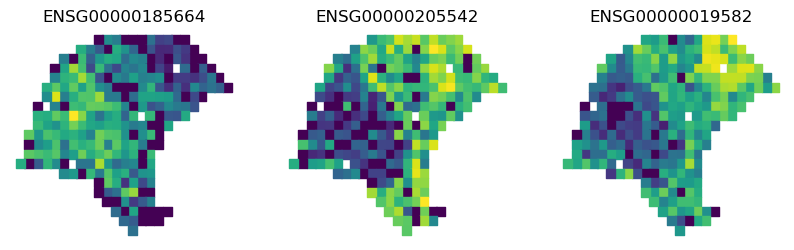

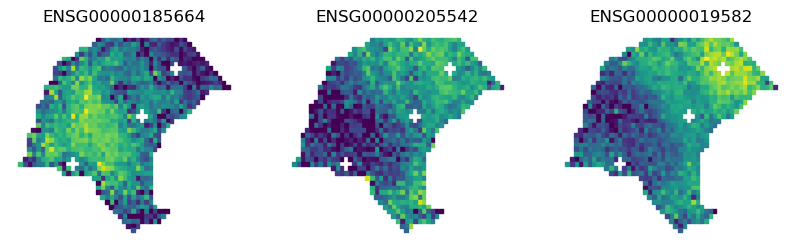

In [24]:
show_genes=['ENSG00000185664','ENSG00000205542','ENSG00000019582']
plot_genes(hidpi_adata, show_genes, n=3, size=(10,6),point_size=42)
plot_genes(imputed_adata, show_genes, n=3, size=(10,6),point_size=8)